# Prédiction de réponse à une campagne marketing

#### Contexte
Une entreprise de e-commerce cherche à optimiser ses campagnes marketing en ciblant les clients les plus susceptibles d’y répondre.

#### Objectif
Développer un modèle permettant de prédire si un client répondra positivement à une campagne marketing à partir de ses comportements d’achat et ses données socio-démographiques.

## 1. Compréhension métier, définition du besoin

### Compréhension du besoin : 

À partir des données dont nous disposons (âge, sexe, revenu annuel, temps passé sur site, achats en ligne) ; essayer de déterminer si un ou plusieurs facteurs permettendt de pouvoir prédire, avec un certain taux de certitude, le fait qu'une personne répondra positivement ou non à la campagne. 


Mesures (target) : taux de réponse (qu'elle soit positifve - 1 ou non - 0) à la campagne marketing

Métriques : F1-Score

## 2.1 et 2.2 Compréhension de la donnée (types de données, visualisations) et nettoyage si nécessaire

In [15]:
import pandas as pd
import numpy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,  confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn

In [16]:
response_df = pd.read_csv("Dataset_Reponse_Marketing.csv")

In [4]:
response_df

,Age,Sexe,Revenu_annuel,Temps_passe_sur_site,Achats_en_ligne,Reponse_campagne
0,22,Homme,40124,16.518974,9,1
1,32,Femme,26307,21.973535,8,1
2,28,Femme,30040,26.762915,9,1
3,16,Femme,15843,29.046008,9,0
4,45,Homme,20225,21.479944,5,0
...,...,...,...,...,...,...
2395,26,Homme,34373,31.567494,10,1
2396,37,Femme,36249,26.347662,10,1
2397,30,Femme,34293,18.275369,7,0
2398,35,Homme,29447,17.211780,6,1


In [5]:
print(response_df.isnull().sum())

Age                     0
Sexe                    0
Revenu_annuel           0
Temps_passe_sur_site    0
Achats_en_ligne         0
Reponse_campagne        0
dtype: int64


In [6]:
print((response_df == "?").sum())
print((response_df == "NA").sum())
print((response_df == "None").sum())

Age                     0
Sexe                    0
Revenu_annuel           0
Temps_passe_sur_site    0
Achats_en_ligne         0
Reponse_campagne        0
dtype: int64
Age                     0
Sexe                    0
Revenu_annuel           0
Temps_passe_sur_site    0
Achats_en_ligne         0
Reponse_campagne        0
dtype: int64
Age                     0
Sexe                    0
Revenu_annuel           0
Temps_passe_sur_site    0
Achats_en_ligne         0
Reponse_campagne        0
dtype: int64


In [7]:
print(response_df.dtypes)

Age                       int64
Sexe                     object
Revenu_annuel             int64
Temps_passe_sur_site    float64
Achats_en_ligne           int64
Reponse_campagne          int64
dtype: object


In [10]:
print("\nInformations sur le DataFrame :")
print(f"Nombre de customers : {response_df.shape[0]}")
print(f"Nombre de variables : {response_df.shape[1] - 1}")  # -1 pour exclure la colonne 'Eleve'
print("\nStatistiques descriptives :")
print(response_df.describe())


Informations sur le DataFrame :
Nombre de customers : 2400
Nombre de variables : 5

Statistiques descriptives :
               Age  Revenu_annuel  Temps_passe_sur_site  Achats_en_ligne  \
count  2400.000000    2400.000000           2400.000000      2400.000000   
mean     34.611250   26197.005000             22.073762         7.642083   
std      10.087287    7062.015627              3.993837         1.612471   
min      -1.000000    4422.000000              8.656394         2.000000   
25%      28.000000   21414.250000             19.381206         7.000000   
50%      35.000000   26222.000000             22.072839         8.000000   
75%      42.000000   30909.250000             24.798229         9.000000   
max      79.000000   50002.000000             37.769324        13.000000   

       Reponse_campagne  
count       2400.000000  
mean           0.526250  
std            0.499415  
min            0.000000  
25%            0.000000  
50%            1.000000  
75%            1.000

In [24]:
print(response_df["Reponse_campagne"].value_counts())

Reponse_campagne
1    1263
0    1137
Name: count, dtype: int64


Observation : répartition dans les catégories de Target équilibrée

In [25]:
# Mettre les données de type "sexe" catégorielles en données numériques dichotomiques

response_encoded = pd.get_dummies(response_df, columns=["Sexe"], drop_first=True)

### Matrice de corrélation

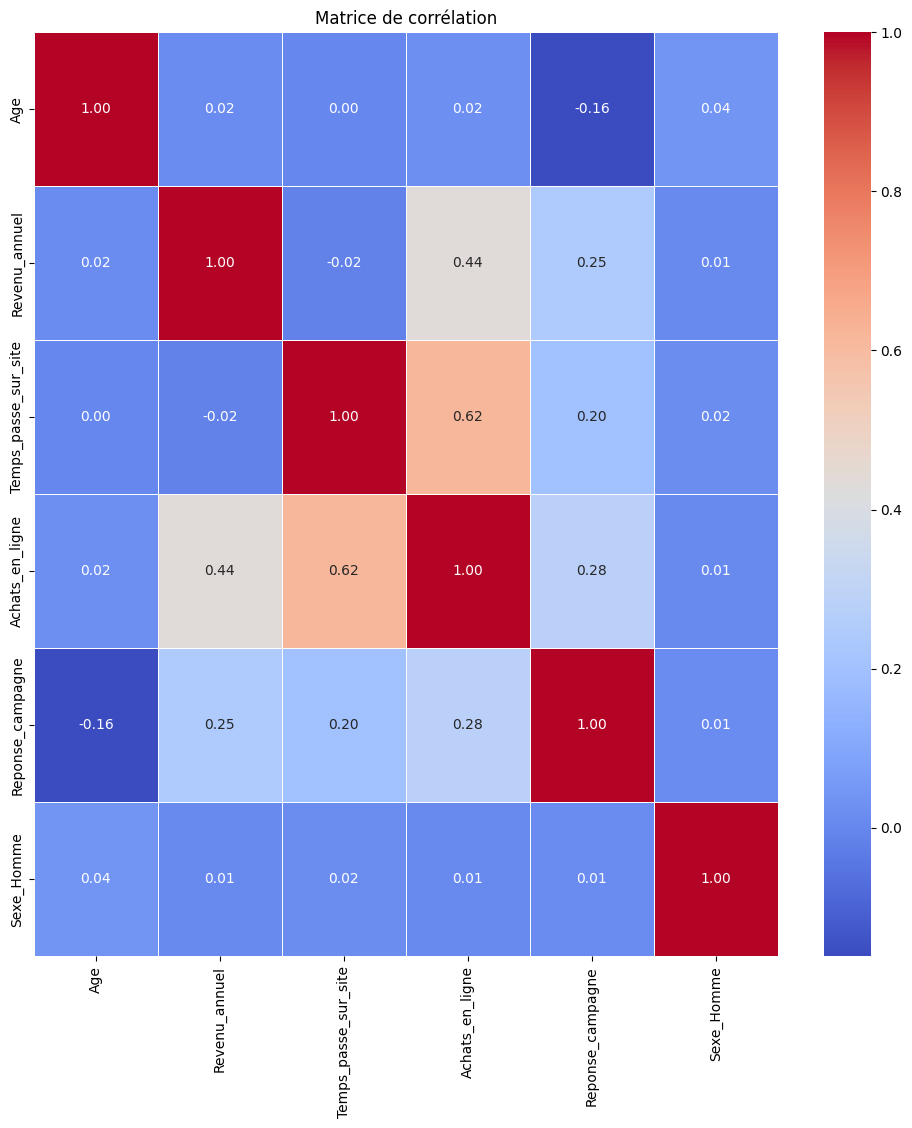

In [38]:
corr_matrix = response_encoded.corr()
plt.figure(figsize=(12, 12))
seaborn.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)

plt.title("Matrice de corrélation")
plt.show()

Observations corrélation : 

Presque toutes les cases sont en bleu, ce qui nous montre ici une ABSENCE DE CORRELATION entre toutes les variables, aucune hétérogénéité (à part une corrélation un peu plus élevée de .06 entre le temps passé sur le site et les achats en ligne).

Ceci donne l'impression qu'aucune variable n'est discriminante dans notre jeu de données.

Les seuls éléments (corrélations) remarquables ici 

### Standardisation des données

In [21]:
# Séparation des variables (suivant votre exemple)
problem = response_df.drop("Reponse_campagne", axis=1)
solution = response_df["Reponse_campagne"]

In [23]:
# Encodage avec get_dummies
problem_encoded = pd.get_dummies(problem, columns=['Sexe'], drop_first=True)

# Standardisation
scaler_object = StandardScaler()
normalized_problem = scaler_object.fit_transform(problem_encoded)

# DataFrame standardisé
normalized_df = pd.DataFrame(normalized_problem, columns=problem_encoded.columns)

print("=== DONNÉES STANDARDISÉES ===")
print("Aperçu :")
print(normalized_df.head())

print(f"\nStatistiques descriptives :")
print(normalized_df.describe())

print(f"\n=== VÉRIFICATION DE LA STANDARDISATION ===")
print("Moyennes (doivent être ≈ 0) :")
print(normalized_df.mean().round(10))
print(f"\nÉcarts-types (doivent être ≈ 1) :")
print(normalized_df.std().round(10))

=== DONNÉES STANDARDISÉES ===
Aperçu :
        Age      Sexe  Revenu_annuel  Temps_passe_sur_site  Achats_en_ligne
0 -1.250473 -1.032184       1.972510             -1.391130         0.842310
1 -0.258919  0.968819       0.015579             -0.025101         0.222014
2 -0.655541  0.968819       0.544292              1.174342         0.842310
3 -1.845405  0.968819      -1.466460              1.746115         0.842310
4  1.030100 -1.032184      -0.845828             -0.148715        -1.638872

Statistiques descriptives :
                Age          Sexe  Revenu_annuel  Temps_passe_sur_site  \
count  2.400000e+03  2.400000e+03   2.400000e+03          2.400000e+03   
mean   1.467345e-16 -4.440892e-17  -1.406282e-16         -8.615331e-16   
std    1.000208e+00  1.000208e+00   1.000208e+00          1.000208e+00   
min   -3.531046e+00 -1.032184e+00  -3.084041e+00         -3.360219e+00   
25%   -6.555408e-01 -1.032184e+00  -6.773918e-01         -6.743182e-01   
50%    3.854664e-02  9.688192e-0

## 3. Modélisation (modèles, métriques)

In [34]:
x_train, x_test, y_train, y_test = train_test_split(normalized_problem, solution)

### PCA

In [35]:
pca_object = PCA()

x_train_pca = pca_object.fit_transform(x_train)

problem = pd.DataFrame(normalized_problem)
pd.DataFrame(pca_object.components_, columns=problem.columns, index=[f"PC_{number}" for number in range(1, len(problem.columns) +1)])


,0,1,2,3,4
PC_1,0.020916,-0.010351,0.402856,0.579210,0.708293
PC_2,-0.448811,0.742995,0.408519,-0.281358,0.021840
PC_3,0.539649,-0.216916,0.654455,-0.483116,0.003730
PC_4,0.711859,0.632929,-0.258039,0.161446,0.002969
PC_5,-0.012953,-0.014125,-0.419432,-0.570865,0.705565


In [36]:
explained_variance = pca_object.explained_variance_ratio_
cumulative_variance = numpy.cumsum(explained_variance)
print("explained_variance:", len(explained_variance))
print("cumulative_variance:", len(cumulative_variance))

explained_variance: 5
cumulative_variance: 5


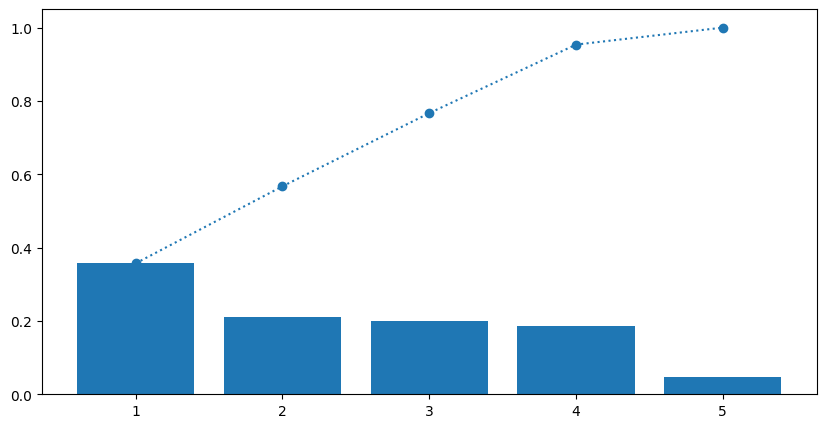

In [37]:
n = len(explained_variance)
plt.figure(figsize=(10, 5))
plt.xticks(ticks= range(1,n+1))
plt.bar(range(1, n+1), explained_variance)
plt.plot(range(1, n+1), cumulative_variance, "o:")
plt.show()

## 4. Validation